# Script scNovel dataset "melanoma"

### Importación de paquetes

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn.metrics
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

### Establecer semilla para reproducibilidad

In [2]:
# Función para establecer la semilla
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 40
set_seed(SEED)

### Carga de datos

In [3]:
# Cargar datos
train_data_path = 'reference_data_com.csv'
train_label_path = 'reference_labels_com.csv'
test_data_path = 'query_data_com.csv'
test_label_path = 'query_labels_com.csv'

adata_train = sc.read_csv(train_data_path)
adata_test = sc.read_csv(test_data_path)

label_train = pd.read_csv(train_label_path)
label_test = pd.read_csv(test_label_path)

label_train.columns = ['Label']
label_test.columns = ['Label']

### Transformación de datos

In [4]:

# Normalizar y log-transformar los datos
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.log1p(adata_train)

sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)

X_train = adata_train.to_df()
X_test = adata_test.to_df()

# Crear status_dict que contenga todas las etiquetas de ambos conjuntos
known_labels = ['T.CD8', 'B.cell', 'T.CD4', 'Macrophage', 'NK']
status_dict = known_labels + ['unassigned']

# Transformar etiquetas de entrenamiento
label_train['transformed'] = label_train['Label'].apply(lambda x: status_dict.index(x) if x in known_labels else status_dict.index('unassigned'))

# Transformar etiquetas de prueba
label_test['transformed'] = label_test['Label'].apply(lambda x: status_dict.index(x) if x in known_labels else status_dict.index('unassigned'))

y_train = torch.tensor(label_train['transformed'].values, dtype=torch.long)
y_test = torch.tensor(label_test['transformed'].values, dtype=torch.long)

# Convertir matrices a tensores
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

# Crear DataLoader para datos de prueba y novel
test_data_typical = Data.TensorDataset(X_test_tensor, y_test)
test_loader_typical = Data.DataLoader(dataset=test_data_typical, batch_size=128, num_workers=1)

train_data = Data.TensorDataset(X_train_tensor, y_train)


### Definir funciones de peso, modelo y parámetros de entrenamiento

In [5]:
# Función para el muestreo ponderado
def Weighted_Sampling(train_label):
    class_sample_count = torch.tensor([(train_label == t).sum() for t in torch.unique(train_label, sorted=True)])
    weight = 1. / class_sample_count.float()
    samples_weight = torch.tensor([weight[t] for t in train_label])
    sampler = Data.WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

sampler = Weighted_Sampling(y_train)
train_loader = Data.DataLoader(dataset=train_data, batch_size=32, sampler=sampler, num_workers=1)

# Definir el modelo
class EnhancedClassifier(nn.Module):
    def __init__(self, input_size, num_class):
        super(EnhancedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_class)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

input_size = X_train_tensor.shape[1]
num_class = len(status_dict)
iteration = 3000  # Aumentar el número de iteraciones

model = EnhancedClassifier(input_size, num_class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computational unit to be used is: {device}")

model.to(device)
model.train()

# Entrenamiento del modelo
count_iteration = 0
while count_iteration < iteration:
    for step, (batch_x, batch_y) in enumerate(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        train_loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        count_iteration += 1
        if count_iteration >= iteration:
            break
    print(f"Finish {count_iteration}/{iteration}")

print("\n--------Annotation Finished----------")

Computational unit to be used is: cpu
Finish 87/3000
Finish 174/3000
Finish 261/3000
Finish 348/3000
Finish 435/3000
Finish 522/3000
Finish 609/3000
Finish 696/3000
Finish 783/3000
Finish 870/3000
Finish 957/3000
Finish 1044/3000
Finish 1131/3000
Finish 1218/3000
Finish 1305/3000
Finish 1392/3000
Finish 1479/3000
Finish 1566/3000
Finish 1653/3000
Finish 1740/3000
Finish 1827/3000
Finish 1914/3000
Finish 2001/3000
Finish 2088/3000
Finish 2175/3000
Finish 2262/3000
Finish 2349/3000
Finish 2436/3000
Finish 2523/3000
Finish 2610/3000
Finish 2697/3000
Finish 2784/3000
Finish 2871/3000
Finish 2958/3000
Finish 3000/3000

--------Annotation Finished----------


### Obtención matriz confusión

Ejemplos de predicciones: [5, 3, 5, 3, 3, 3, 3, 3, 3, 5]
Ejemplos de etiquetas verdaderas: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Distribución de predicciones: Counter({5: 1465, 3: 963, 0: 491, 1: 244, 2: 235, 4: 14})


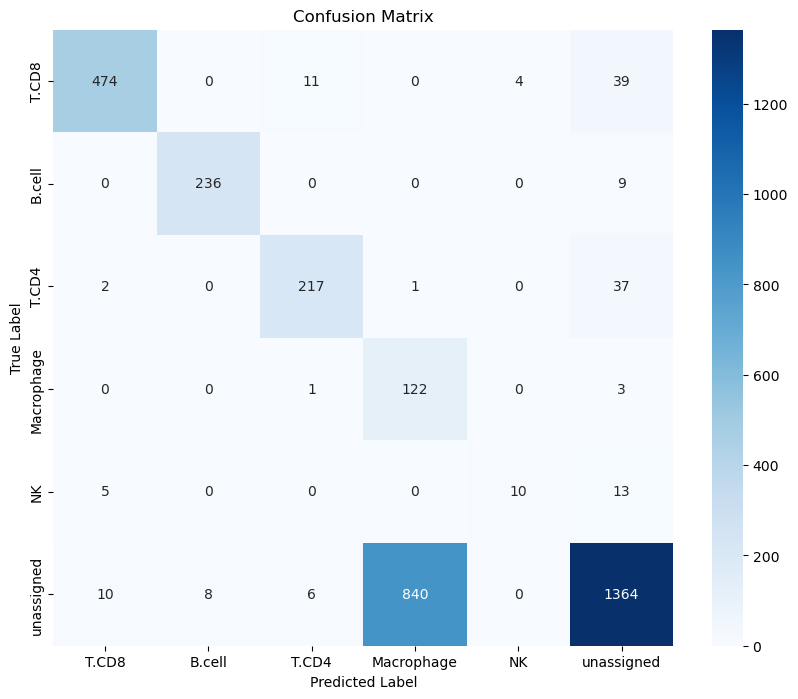

In [6]:
from scNovel.score_functions import get_ood_scores
model.eval()

# Función para aplicar el preprocesamiento de códigos de barras
def barcode_preprocessing(x, epsilon=0.0014):
    x_plus = x + epsilon * torch.sign(torch.autograd.grad(outputs=x.max(), inputs=x, create_graph=True)[0])
    x_minus = x - epsilon * torch.sign(torch.autograd.grad(outputs=x.min(), inputs=x, create_graph=True)[0])
    return x_plus, x_minus

# Obtener predicciones
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch_x, batch_y in test_loader_typical:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Ajustar predicciones para asignar células no conocidas como "unassigned"
threshold = 0.98  # Umbral para determinar si una célula es "unassigned"
all_preds_adjusted = []
for pred, prob in zip(all_preds, all_probs):
    max_prob = np.max(prob)
    if max_prob < threshold:
        all_preds_adjusted.append(status_dict.index('unassigned'))
    else:
        all_preds_adjusted.append(pred)

# Verificación de predicciones y etiquetas
print("Ejemplos de predicciones:", all_preds_adjusted[:10])
print("Ejemplos de etiquetas verdaderas:", all_labels[:10])
print("Distribución de predicciones:", Counter(all_preds_adjusted))

# Generar matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds_adjusted)

# Crear etiquetas del eje x
xticks_labels = status_dict

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticks_labels, yticklabels=status_dict)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Matriz de confusión con proporciones relativas

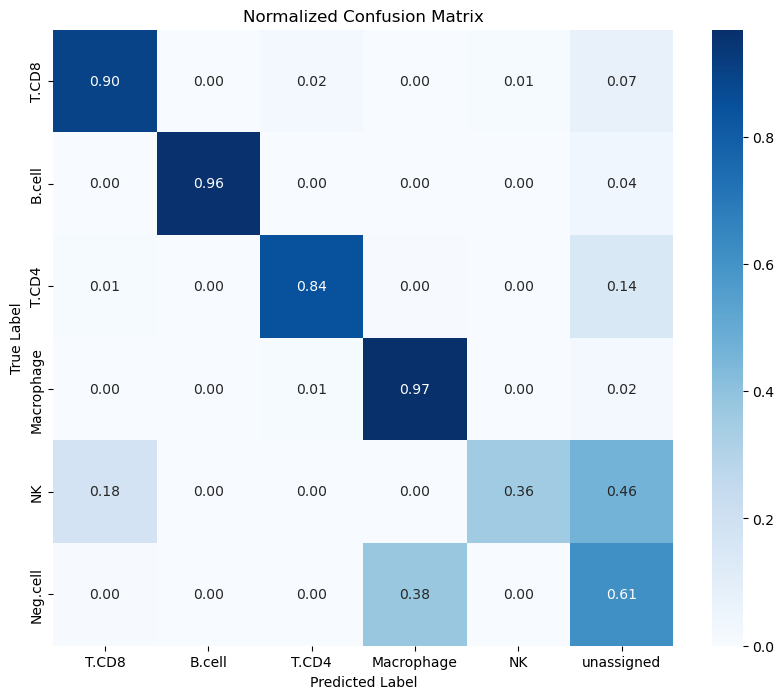

In [7]:
# Convertir los conteos absolutos a proporciones relativas
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Etiquetas de los ejes
status_dict = ['T.CD8', 'B.cell', 'T.CD4', 'Macrophage', 'NK', 'unassigned']
xticks_labels = status_dict

# Cambiar la etiqueta 'unassigned' en el eje vertical a 'Neg.cell'
yticks_labels = ['T.CD8', 'B.cell', 'T.CD4', 'Macrophage', 'NK', 'Neg.cell']

# Visualizar la matriz de confusión normalizada con las etiquetas actualizadas
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=xticks_labels, yticklabels=yticks_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

### Análisis UMAP

In [8]:
model.eval()

# Obtener predicciones
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch_x, batch_y in test_loader_typical:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Ajustar predicciones para asignar células no conocidas como "unassigned"
threshold = 0.98  # Umbral para determinar si una célula es "unassigned"
all_preds_adjusted = []
for pred, prob in zip(all_preds, all_probs):
    max_prob = np.max(prob)
    if max_prob < threshold:
        all_preds_adjusted.append(status_dict.index('unassigned'))
    else:
        all_preds_adjusted.append(pred)



C:\Users\racer\AppData\Local\Temp\ipykernel_18464\2752776106.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_train.concatenate(adata_test, batch_key='origin', batch_categories=['train', 'test'])


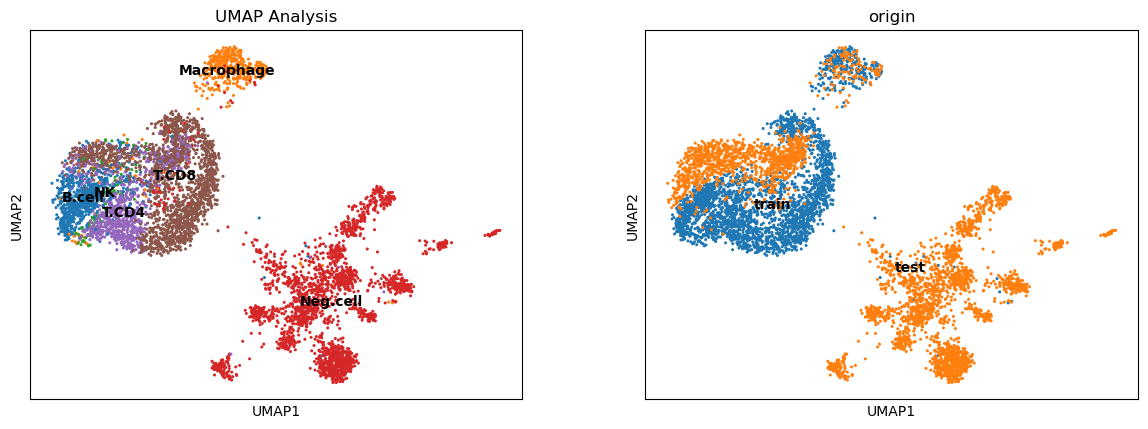

In [9]:
# Concatenar datos de entrenamiento y prueba para UMAP
adata_combined = adata_train.concatenate(adata_test, batch_key='origin', batch_categories=['train', 'test'])

# Añadir etiquetas
labels_combined = pd.concat([label_train, label_test])
adata_combined.obs['labels'] = labels_combined['Label'].values

# Aplicar UMAP
sc.pp.neighbors(adata_combined, n_neighbors=15, use_rep='X')
sc.tl.umap(adata_combined)

# Visualizar UMAP
sc.pl.umap(adata_combined, color=['labels', 'origin'], legend_loc='on data', title='UMAP Analysis')
plt.show()

<Figure size 800x800 with 0 Axes>

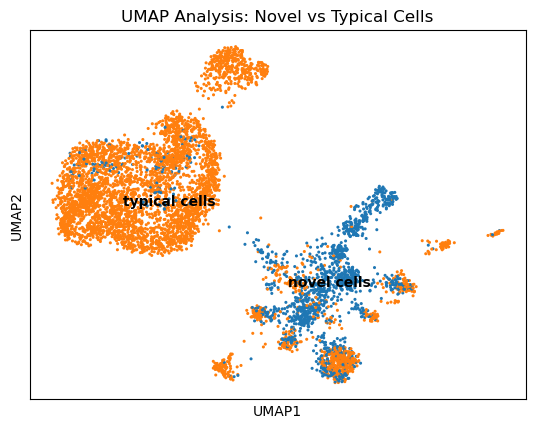

In [10]:
# Agregar las predicciones ajustadas al objeto anndata combinado
labels_combined = np.concatenate((label_train['transformed'].values, all_preds_adjusted))
adata_combined.obs['cell_type'] = ['novel cells' if x == status_dict.index('unassigned') else 'typical cells' for x in labels_combined]

# Aplicar UMAP
sc.pp.neighbors(adata_combined, n_neighbors=15, use_rep='X')
sc.tl.umap(adata_combined)

# Visualizar UMAP
plt.figure(figsize=(8, 8))
sc.pl.umap(adata_combined, color=['cell_type'], legend_loc='on data', title='UMAP Analysis: Novel vs Typical Cells', show=True)

### Curvo ROC

In [11]:
from sklearn.preprocessing import label_binarize

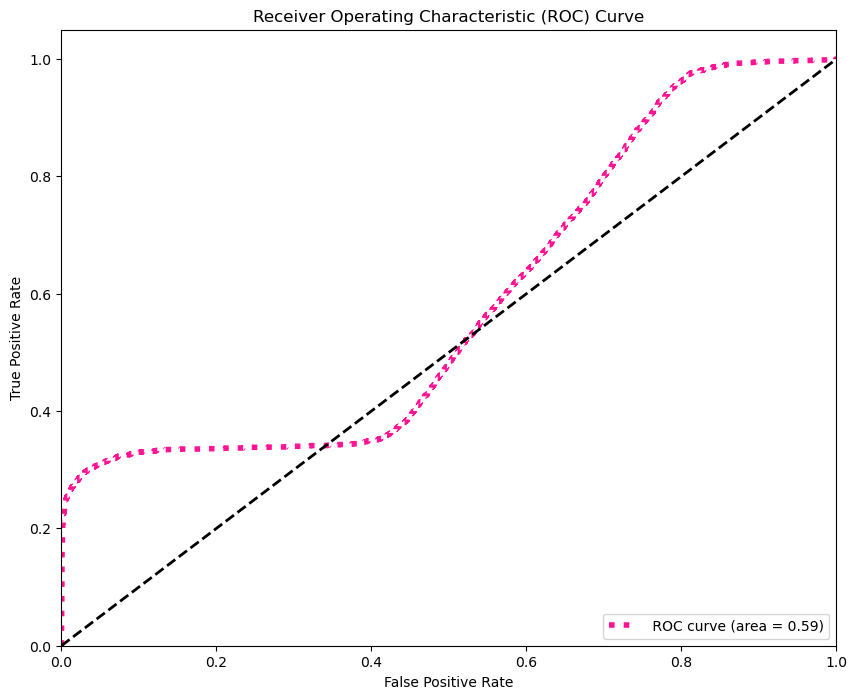

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que ya tenemos `all_labels` y `all_probs` del código anterior
# Binarizar las etiquetas para cada clase
y_true = label_binarize(all_labels, classes=[0, 1, 2, 3, 4, 5])  # Asumiendo que hay 6 clases en total

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC micro-promediada y macro-promediada
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), np.array(all_probs).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Visualizar la curva ROC general
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label=' ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Extracción clúster de novel cells

C:\Users\racer\AppData\Local\Temp\ipykernel_18464\1029509324.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(unassigned_data, resolution=0.5)


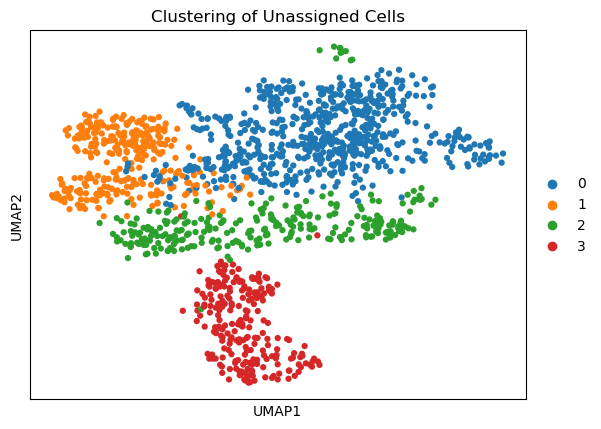

In [13]:
import scanpy as sc
import pandas as pd
import numpy as np

# Extraer las células "unassigned"
unassigned_indices = [i for i, pred in enumerate(all_preds_adjusted) if pred == status_dict.index('unassigned')]
unassigned_data = adata_test[unassigned_indices]

# Realizar clustering en las células "unassigned"
sc.pp.neighbors(unassigned_data, n_neighbors=15, use_rep='X')
sc.tl.umap(unassigned_data)
sc.tl.leiden(unassigned_data, resolution=0.5)

# Visualizar el resultado del clustering (opcional)
sc.pl.umap(unassigned_data, color=['leiden'], title='Clustering of Unassigned Cells')

# Convertir matriz de expresión génica a DataFrame
unassigned_df = pd.DataFrame(unassigned_data.X, index=unassigned_data.obs_names, columns=unassigned_data.var_names)

# Guardar el DataFrame como CSV para importar en R
unassigned_df.to_csv('unassigned_expression_data.csv')

##print("Datos de expresión del clúster 'unassigned' guardados en 'unassigned_expression_data.csv'")